# Pearson Correlation Coefficient between alt-coins and the Bitcoin.

A simple data analysis in python using pandas (https://pandas.pydata.org/). The goal of this analysis is to determine the statistical distribution of the Pearson correlation coefficients (https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between most of the currently (Nov/2021) listed alt-coins in the Binance Crypto Exchange and the Bitcoin.

In [1]:
from datetime import datetime, timedelta

from binance import Client, enums  # To connect to the Binance market data endpoint
from matplotlib import pyplot as plt  # To plot the distribution
import pandas as pd  # To process the data

Let us now connect to the Binance API and get all the currently available pairs of (base)/USDT.

In [2]:
client = Client()
symbols_info = client.get_exchange_info()['symbols']
symbols = [s['symbol'] for s in symbols_info if s['quoteAsset'] == 'USDT']

Let us see how many symbols we got and also see some of them:

In [3]:
print(f'Total symbols: {len(symbols)} |', symbols[:5])

Total symbols: 346 | ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'BCCUSDT', 'NEOUSDT']


The correlation we are looking for is that between the daily percentage change ((close - open)/open) of an alt-coin and that of the Bitcoin. To achieve this, we are now going to get the daily percentage change of the Bitcoin and then do the same to the alt-coins to find the correlation.

We are going to use all the data from 365 days ago up 2021-11-01.

In [4]:
start_day = (datetime.now() - timedelta(days=365)).strftime(r'%Y-%m-%d')
print(f'Data from {start_day} up to 2021-11-01.')

Data from 2020-11-01 up to 2021-11-01.


Let us create a function to clean up the data from the API and return the daily percentage change as a pandas Series:

In [5]:
def daily_pct_change(symbol: str, start_date: str) -> pd.Series:
    """
    Return the (symbol)'s daily percentage change from (start_date) up to now.
        Parameters:
                symbol: the pair (base)/(quote) [str]
                start_date: get price data from start_date up to now [str]
        Returns:
                A pandas Series
    """
    ohlcv = client.get_historical_klines(
        symbol, enums.KLINE_INTERVAL_1DAY, start_date
    )
    change = [
        (float(entry[4]) - float(entry[1]))/float(entry[1]) for entry in ohlcv
    ]
    #  entry[1]: open price | entry[4]: close price
    
    return pd.Series(change, dtype='float64')

In [6]:
btcusdt_changes = daily_pct_change('BTCUSDT', start_day)
print(btcusdt_changes)
#  0 is the furthest day and 366 is today.

0     -0.002139
1     -0.015414
2      0.034975
3      0.008591
4      0.102235
         ...   
361    0.037020
362    0.027698
363   -0.006337
364   -0.009043
365   -0.007938
Length: 366, dtype: float64


Since we already have the daily percentage changes for BTCUSDT, let us remove this symbol from the list of symbols and then calculate the Pearson correlation coefficient between each of them and the BTCUSDT.

In [7]:
symbols.remove('BTCUSDT')

In [8]:
coeffs = {}
for symbol in symbols:
    symbol_changes = daily_pct_change(symbol, start_day)
    coeffs[symbol] = btcusdt_changes.corr(symbol_changes, min_periods=300)
coeffs = pd.Series(coeffs).dropna()

Let us now sort the pandas Series in descending order and see the pairs that most positively correlate with Bitcoin and those that most negatively correlate with Bitcoin:

In [9]:
coeffs.sort_values(ascending=False, inplace=True)
print(coeffs)

BTCUPUSDT      0.991306
LTCUSDT        0.766276
LTCUPUSDT      0.764553
ETHUSDT        0.745077
ETHUPUSDT      0.740586
                 ...   
TRXDOWNUSDT   -0.606683
EOSDOWNUSDT   -0.620988
ETHDOWNUSDT   -0.637220
LTCDOWNUSDT   -0.651752
BTCDOWNUSDT   -0.975012
Length: 222, dtype: float64


Finally, let us plot the distribuition:

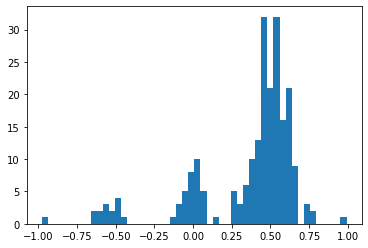

In [10]:
dist = plt.hist(coeffs, bins=50)

As there seem to be outliers in the dataset, let us calculate the median of the distribution as the center of the data:

In [11]:
median = coeffs.median()
print('median:', median)

median: 0.4773181169110403


# Conclusion

In this brief analysis, we calculated the Pearson correlation coefficients between 222 alt-coins and the Bitcoin. We fetched one year worth of data from the Binance Exchange API. We plotted the distribution of the coefficients and arrived at a value of approximately 0.477 for the median. Therefore, we conclude that most of the alt-coins had a positive correlation of 47.7% with the Bitcoin in the past year.